In [76]:
# %% Import
import pandas as pd
import sys
import os
import pymc3 as pm
import theano.tensor as tt
import arviz as az
import numpy as np

module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path)

from forseti.datproc import translate_categorical, extract_sensitive

In [77]:
# %% Translate Categorical Attributes
df = pd.read_csv('data/adult.csv')
tmp, codes = translate_categorical(df)

In [108]:
# %% Extract sensitive attributes
sensattr = ['gender', 'race']
sensitive, features = extract_sensitive(tmp, sensattr)

In [127]:
sensitive = sensitive.astype('int64')
y = features['income'].astype('int64')
X = features.drop(['income', 'fnlwgt'], axis=1).astype('int64')

In [199]:
with pm.Model() as model:
    # Data
    S_shared = pm.Data("S_obsered", sensitive['gender'][:100])
    D_shared = pm.Data("D_observed", y[:100])
    W_shared_T = pm.Data("W_observed:T", X['workclass'][:100].values.reshape(-1, 1))
    W_shared = pm.Data("W_observed", X['workclass'][:100])

    # Data info
    nparam = 1
    nclass = len(X['workclass'].unique())

    # Sensitive Attribute
    beta_s = pm.Dirichlet("beta_s", np.ones(2))
    S = pm.Categorical("S", p=beta_s, observed=S_shared)

    # Fair Labels
    beta_f = pm.Dirichlet("beta_f", np.ones(2))
    Df = pm.Categorical("Df", p=beta_f)

    # Data Labels P(D | Df, S)
    intercept_D = pm.Normal("intercept_D", mu=0, sd=1)
    beta1_D = pm.Normal("beta1_D", mu=0, sd=1)
    beta2_D = pm.Normal("beta2_D", mu=0, sd=1)
    mu_D = pm.math.invlogit(intercept_D + beta1_D*S + beta2_D*Df)
    D = pm.Bernoulli("D", p=mu_D, observed=D_shared)

    # Data Labels P(W | Df, S)
    alpha_W = pm.Normal('alpha_W', mu=0, sd=1, shape=(nclass))
    beta_W = pm.Normal('beta_w', mu=0, sd=1, shape=(nparam, nclass))
    mu = alpha_W + tt.dot(W_shared_T, beta_W)
    p = tt.nnet.softmax(mu)
    W = pm.Categorical('W', p=p, observed=W_shared)

    # Sample
    trace = pm.sample(50)

/tmp/ipykernel_5138/3148140738.py:35: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(50)
Only 50 samples in chain.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [beta_w, alpha_W, beta2_D, beta1_D, intercept_D, beta_f, beta_s]
>BinaryGibbsMetropolis: [Df]


Sampling 4 chains for 1_000 tune and 50 draw iterations (4_000 + 200 draws total) took 26 seconds.
/home/bcwein/anaconda3/envs/forseti/lib/python3.9/site-packages/pymc3/sampling.py:643: UserWarning: The number of samples is too small to check convergence reliably.
  warnings.warn("The number of samples is too small to check convergence reliably.")


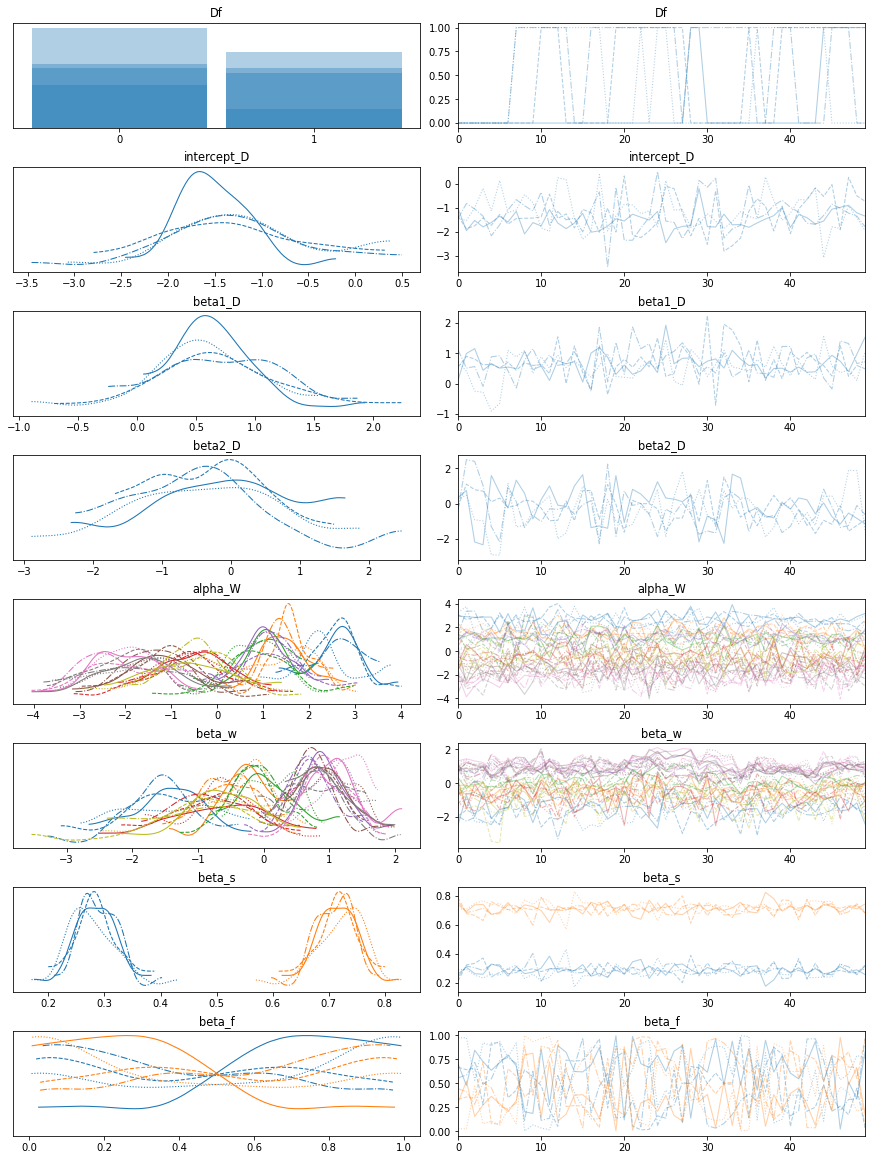

In [200]:
with model:
    az.plot_trace(trace)